# Processing ZEN data with Aurora

This is an example of how to process ZEN data with Aurora.  For now this is an example of how to process data in the field to get a first-order estimate of what the MT response looks like. 

The order will be:

1. Connect laptop to ZEN and put in SD mode
2. Copy only the files for the desired station
3. Create an MTH5 from the data
4. Processes the a 256 run and a 4096 run
5. Plot results

In [1]:
%matplotlib widget

In [2]:
from pathlib import Path

from mth5 import read_file
from mth5.io.zen import Z3DCollection, zen_tools
from mth5.mth5 import MTH5
from mtpy import MT

C:\Users\peaco\anaconda3\envs\mt\lib\_collections_abc.py:720: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  yield from self._mapping
C:\Users\peaco\Documents\GitHub\mtpy\mtpy\imaging\mtcolors.py:284: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  cmapdict.update(cm.cmap_d)


If you want to write a vtk file for 3d viewing, you need to install pyevtk
If you want to write a vtk file for 3d viewing, you need to install pyevtk
If you want to write a vtk file for 3d viewing, you need to install pyevtk
If you want to write a vtk file for 3d viewing, you need to install pyevtk


## Important Parameters

Set some important parameters up from so you don't have to search through the notebook.

In [16]:
station = "bv92"
save_path = Path(r"c:\MT\BV2023").joinpath(station)
mth5_path = save_path.joinpath(f"{station}_with_1s_run.h5")
combine = True

## 2. Create MTH5

Now that the data is downloaded we need to create a MTH5 from which we can visualize and process.  

### Organize data into Runs

The first step is to take an inventory of the data and organize the channels into runs.  This can be done with `Z3DCollection`.  It will group by start time and sample rate, then assign run names with the sample rate and a number indicator.  `sr256_0001` is the first run in the sequence with a sample rate of 256.

In [17]:
zc = Z3DCollection(save_path)
runs = zc.get_runs(sample_rates=[4096, 1024, 256])

zen_station = list(runs.keys())[0]

### Create MTH5

Here we are going to create an MTH5 by iterating over the runs detected with `Z3DCollection`.  We are also going to combine all runs together and downsample to 1 second to use with observatory data as a remote reference. Gaps between schedule actions are filled with mean values and are too small to effect processing, usually 10-20 seconds of missing data.

<div class="alert alert-block alert-warning">
<b>IMPORTANT:</b> Set the survey name as this will be used to place the data under a survey name.  
</div> 

<div class="alert alert-block alert-warning">
<b>IMPORTANT:</b> Be sure to set the path to the induction coil calibration file (usually 'amtant.cal') because the calibration data that comes directly off the Z3D is not correct at the moment, not sure if that is an error in reading or writing.   
</div> 

In [18]:
%%time
with MTH5() as m:
    m.open_mth5(mth5_path)
    survey_group = m.add_survey("BV2023")
    for station_id in runs.keys():
        station_group = survey_group.stations_group.add_station(station_id)
        station_group.metadata.update(zc.station_metadata_dict[station_id])
        station_group.write_metadata()
        if combine:
            run_list = []
        for run_id, run_df in runs[station_id].items():
            run_group = station_group.add_run(run_id)
            for row in run_df.itertuples():
                ch_ts = read_file(
                    row.fn,
                    calibration_fn=r"c:\MT\antenna.cal",
                )
                run_group.from_channel_ts(ch_ts)
            run_group.update_run_metadata()
            if combine:
                run_list.append(run_group.to_runts())

        if combine:
            # Combine runs and down sample to 1 second.
            combined_run = run_list[0].merge(run_list[1:], new_sample_rate=1)
            combined_run.run_metadata.id = "sr1_0001"
            combined_run_group = station_group.add_run("sr1_0001")
            combined_run_group.from_runts(combined_run)
            combined_run_group.update_run_metadata()

        station_group.update_station_metadata()

    survey_group.update_survey_metadata()

2023-07-23T14:08:06.100718-0700 | INFO | mth5.mth5 | _initialize_file | Initialized MTH5 0.2.0 file c:\MT\BV2023\bv92\bv92_with_1s_run.h5 in mode a
2023-07-23T14:08:14.890678-0700 | INFO | mth5.timeseries.run_ts | _align_channels | Channels do not have a common end, using latest: 2023-07-22T19:09:41.998535000
2023-07-23T14:08:17.410418-0700 | WARNING | mth5.timeseries.run_ts | validate_metadata | end time of dataset 2023-07-22T19:09:41.998291+00:00 does not match metadata end 2023-07-22T19:09:41.998535+00:00 updating metatdata value to 2023-07-22T19:09:41.998291+00:00
2023-07-23T14:08:35.255525-0700 | INFO | mth5.timeseries.run_ts | _align_channels | Channels do not have a common end, using latest: 2023-07-23T01:09:41.998779000
2023-07-23T14:08:37.793771-0700 | WARNING | mth5.timeseries.run_ts | validate_metadata | end time of dataset 2023-07-23T01:09:41.998535+00:00 does not match metadata end 2023-07-23T01:09:41.998779+00:00 updating metatdata value to 2023-07-23T01:09:41.998535+00:0

### Combined Run

Here is the combined run data sampled at 1 Hz.

RunTS Summary:
	Survey:      BV2023
	Station:     107
	Run:         sr1_0001
	Start:       2023-07-22T19:44:58+00:00
	End:         2023-07-23T16:54:42+00:00
	Sample Rate: 1.0
	Components:  ['ex', 'ey', 'hx', 'hy', 'hz']


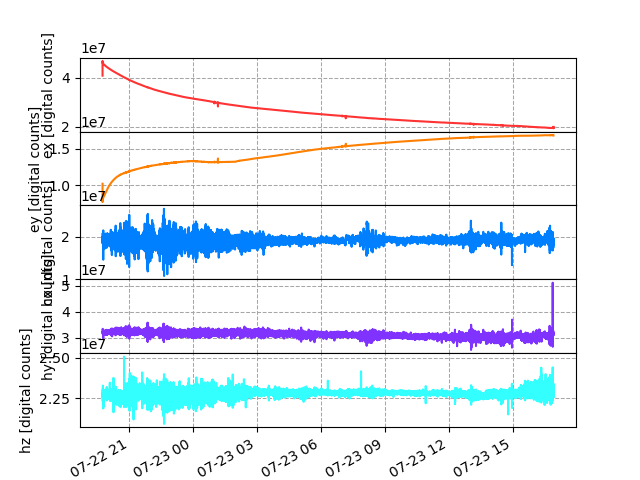

In [6]:
if combine:
    print(combined_run.__str__())
    combined_run.plot()

## Process With Aurora

In [19]:
# Required imports for the program.
import warnings
from pathlib import Path

from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from aurora.pipelines.run_summary import RunSummary
from aurora.transfer_function.kernel_dataset import KernelDataset

from mth5.helpers import close_open_files

warnings.filterwarnings("ignore")

In [30]:
survey_dir = Path(r"c:\MT\BV2023")
local_station = "bv107"
local_zen_station = local_station[2:]
local_mth5 = survey_dir.joinpath(local_station, f"{local_station}_with_1s_run.h5")

rr_station = "bv83"
rr_zen_station = rr_station[2:]
remote_mth5 = survey_dir.joinpath(rr_station, f"{rr_station}_with_1s_run.h5")

In [34]:
close_open_files()

sample_rate = 4096
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([local_mth5, remote_mth5])
run_summary = mth5_run_summary.clone()
run_summary.add_duration()
run_summary.df = run_summary.df[run_summary.df.sample_rate == sample_rate].iloc[:]
run_summary.mini_summary

2023-07-23T14:25:05.068679-0700 | INFO | mth5.mth5 | close_mth5 | Flushing and closing c:\MT\BV2023\bv107\bv107_with_1s_run.h5
2023-07-23T14:25:05.479201-0700 | INFO | mth5.mth5 | close_mth5 | Flushing and closing c:\MT\BV2023\bv83\bv83_with_1s_run.h5


,survey,station_id,run_id,start,end
2,BV2023,107,sr4096_0002,2023-07-23 00:59:58+00:00,2023-07-23 01:09:41.997803+00:00
4,BV2023,107,sr4096_0004,2023-07-23 06:59:58+00:00,2023-07-23 07:09:41.982666+00:00
6,BV2023,107,sr4096_0006,2023-07-23 12:59:58+00:00,2023-07-23 13:09:41.995361+00:00
10,BV2023,83,sr4096_0002,2023-07-22 18:59:58+00:00,2023-07-22 19:09:41.997070+00:00
12,BV2023,83,sr4096_0004,2023-07-23 00:59:58+00:00,2023-07-23 01:09:41.996582+00:00
14,BV2023,83,sr4096_0006,2023-07-23 06:59:58+00:00,2023-07-23 07:09:41.995117+00:00
16,BV2023,83,sr4096_0008,2023-07-23 12:59:58+00:00,2023-07-23 13:09:41.996582+00:00


In [35]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, local_zen_station, rr_zen_station)
mimimum_run_duration = 100  # seconds
kernel_dataset.drop_runs_shorter_than(mimimum_run_duration)
kernel_dataset.mini_summary

,survey,station_id,run_id,start,end,duration
0,BV2023,107,sr4096_0002,2023-07-23 00:59:58+00:00,2023-07-23 01:09:41.996582+00:00,583.996582
1,BV2023,83,sr4096_0004,2023-07-23 00:59:58+00:00,2023-07-23 01:09:41.996582+00:00,583.996582
2,BV2023,107,sr4096_0004,2023-07-23 06:59:58+00:00,2023-07-23 07:09:41.982666+00:00,583.982666
3,BV2023,83,sr4096_0006,2023-07-23 06:59:58+00:00,2023-07-23 07:09:41.982666+00:00,583.982666
4,BV2023,107,sr4096_0006,2023-07-23 12:59:58+00:00,2023-07-23 13:09:41.995361+00:00,583.995361
5,BV2023,83,sr4096_0008,2023-07-23 12:59:58+00:00,2023-07-23 13:09:41.995361+00:00,583.995361


In [36]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(
    kernel_dataset,
    emtf_band_file=r"c:\Users\peaco\Documents\GitHub\aurora\aurora\config\emtf_band_setup\bs_six_level.cfg",
)

for decimation in config.decimations:
    decimation.estimator.engine = "RME_RR"
    decimation.window.type = "hamming"
    decimation.output_channels = ["ex", "ey", "hz"]

c:\Users\peaco\Documents\GitHub\aurora\aurora\config\emtf_band_setup\bs_six_level.cfg


In [37]:
%%time
tf_cls = process_mth5(
    config,
    kernel_dataset,
    units="MT",
    show_plot=False,
    z_file_path=None,
)
print("=== FINISHED ===")

edi = tf_cls.write(mth5_path.parent.joinpath(f"{station}_{sample_rate}.edi"))

# plot with MTpy
mt_obj = MT()
mt_obj.read(edi.fn)
p1 = mt_obj.plot_mt_response(fig_num=6, plot_num=2)
p1.save_plot(save_path.joinpath(f"{edi.fn.stem}.png"), fig_dpi=300, close_plot=False)

2023-07-23T14:25:30.137817-0700 | INFO | aurora.pipelines.transfer_function_kernel | memory_warning | Total memory: 7.87 GB
2023-07-23T14:25:30.137817-0700 | INFO | aurora.pipelines.transfer_function_kernel | memory_warning | Total Bytes of Raw Data: 0.107 GB
2023-07-23T14:25:30.150237-0700 | INFO | aurora.pipelines.transfer_function_kernel | memory_warning | Raw Data will use: 1.358 % of memory
2023-07-23T14:25:33.601210-0700 | WARNING | mth5.groups.master_station_run_channel | time_slice | Requested slice is larger than data.  Slice length = 2392050, data length = (2392028,). Setting end_index to (2392028,)
2023-07-23T14:25:36.608650-0700 | INFO | mth5.timeseries.run_ts | _align_channels | Channels do not have a common end, using latest: 2023-07-23T01:09:41.996338000
2023-07-23T14:25:39.092374-0700 | WARNING | mth5.timeseries.run_ts | validate_metadata | end time of dataset 2023-07-23T01:09:41.996338+00:00 does not match metadata end 2023-07-23T01:09:41.998535+00:00 updating metatdat

ValueError: indexes along dimension 'observation' are not equal